In [58]:
import json
import re
import subprocess
import os
import sqlite3 as lite
import copy
import glob
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import d3ploy.tester as tester
import d3ploy.plotter as plotter
import collections
from IPython.display import Image
from IPython.display import display

# Delete previously generated files
direc = os.listdir('./')
hit_list = glob.glob('*.sqlite') + glob.glob('*.json') + \
    glob.glob('*.png') + glob.glob('*.csv') + glob.glob('*.txt')
for file in hit_list:
    os.remove(file)

ENV = dict(os.environ)
ENV['PYTHONPATH'] = ".:" + ENV.get('PYTHONPATH', '')


In [59]:
scenario_template = {
    "simulation": {
        "archetypes": {
            "spec": [
                    {"lib": "agents", "name": "NullRegion"},
                    {"lib": "cycamore", "name": "Source"},
                    {"lib": "cycamore", "name": "Reactor"},
                    {"lib": "cycamore", "name": "Sink"},
                    {"lib": "cycamore", "name": "Storage"},
                    {"lib": "d3ploy.demand_driven_deployment_inst", "name": "DemandDrivenDeploymentInst"},
                    {"lib": "d3ploy.supply_driven_deployment_inst", "name": "SupplyDrivenDeploymentInst"}
            ]
        },
        "control": {"duration": "100", "startmonth": "1", "startyear": "2000"},
        "recipe": [
            {
                "basis": "mass",
                "name": "fresh_uox",
                "nuclide": [{"comp": "0.711", "id": "U235"}, {"comp": "99.289", "id": "U238"}]
            },
            {
                "basis": "mass",
                "name": "spent_uox",
                "nuclide": [{"comp": "50", "id": "Kr85"}, {"comp": "50", "id": "Cs137"}]
            }
        ]}}

In [60]:
demand_eq = "1000"

scenario_3_input = copy.deepcopy(scenario_template)
scenario_3_input["simulation"].update({"facility": [{
    "config": {"Source": {"outcommod": "fuel",
                            "outrecipe": "fresh_uox",
                            "throughput": "3000"}},
    "name": "source"
},
    {
    "config": {"Sink": {"in_commods": {"val": "spentfuel"},
                        "max_inv_size": "1e6"}},
    "name": "sink"
},
    {
    "config": {
        "Reactor": {
            "assem_size": "1000",
            "cycle_time": "18",
            "fuel_incommods": {"val": "fuel"},
            "fuel_inrecipes": {"val": "fresh_uox"},
            "fuel_outcommods": {"val": "spentfuel"},
            "fuel_outrecipes": {"val": "spent_uox"},
            "n_assem_batch": "1",
            "n_assem_core": "3",
            "power_cap": "1000",
            "refuel_time": "1",
        }
    },
    "name": "reactor"
}]})
scenario_3_input["simulation"].update({"region": {   "config": {"NullRegion": "\n      "}, 
"institution": [
{
    "config": {
    "DemandDrivenDeploymentInst": {
    "calc_method": "fft", 
    "demand_eq": demand_eq , 
    "driving_commod": "POWER", 
    "facility_capacity": {"item": {"capacity": "3000", "facility": "source"}}, 
    "facility_commod": {"item": {"commod": "fuel", "facility": "source"}}, 
    #"supply_buffer":{"item": {"commod": "fuel", "buffer": "0.5"}}, 
    "record": "0", 
    "steps": "1"
    }
    }, 
    "name": "non_driving_inst"
}, 
{
    "config": {
    "DemandDrivenDeploymentInst": {
    "calc_method": "ma", 
    "demand_eq": demand_eq , 
    "driving_commod": "POWER", 
    "facility_capacity": {"item": {"capacity": "1000", "facility": "reactor"}}, 
    "facility_commod": {"item": {"commod": "POWER", "facility": "reactor"}}, 
    "buffer_type":{"item": {"commod": "POWER", "type": "float"}}, 
    "supply_buffer":{"item": {"commod": "POWER", "buffer": "1000"}}, 
    "record": "0", 
    "steps": "1"
    }
    }, 
    "name": "driving_inst"
}
], 
"name": "SingleRegion"

}})

In [61]:
metric_dict = {}
demand_eq = '1000'

name = "scenario_3_input_"
input_file = name + ".json"
output_file = name + ".sqlite"
with open(input_file, 'w') as f:
    json.dump(scenario_3_input, f)

s = subprocess.check_output(['cyclus', '-o', output_file, input_file],
                            universal_newlines=True,)

# Initialize dicts
all_dict_power = {}
all_dict_fuel = {}
agent_entry_dict = {}

all_dict_power = tester.supply_demand_dict_driving(
    output_file, demand_eq, 'power')
all_dict_fuel = tester.supply_demand_dict_nondriving(
    output_file, 'fuel', True)

agent_entry_dict['power'] = tester.get_agent_dict(output_file, ['reactor'])
agent_entry_dict['fuel'] = tester.get_agent_dict(output_file, ['source'])
# plots demand, supply, calculated demand, calculated supply for the
# scenario for each calc method
plotter.plot_demand_supply_agent(
    all_dict_power,
    agent_entry_dict['power'],
    'power',
    name + '_power',
    True,
    False,
    True)
plotter.plot_demand_supply_agent(
    all_dict_fuel,
    agent_entry_dict['fuel'],
    'fuel',
    name + '_fuel',
    True,
    False,
    False)

calc_method = "scenario3"

metric_dict = tester.metrics(
    all_dict_power,
    metric_dict,
    calc_method,
    'power',
    True)
metric_dict = tester.metrics(
    all_dict_fuel,
    metric_dict,
    calc_method,
    'fuel',
    True)

df = pd.DataFrame(metric_dict)
df.to_csv('scenario_3_output.csv')

In [44]:
df

,power_undersupply,fuel_undersupply
scenario3,2,1


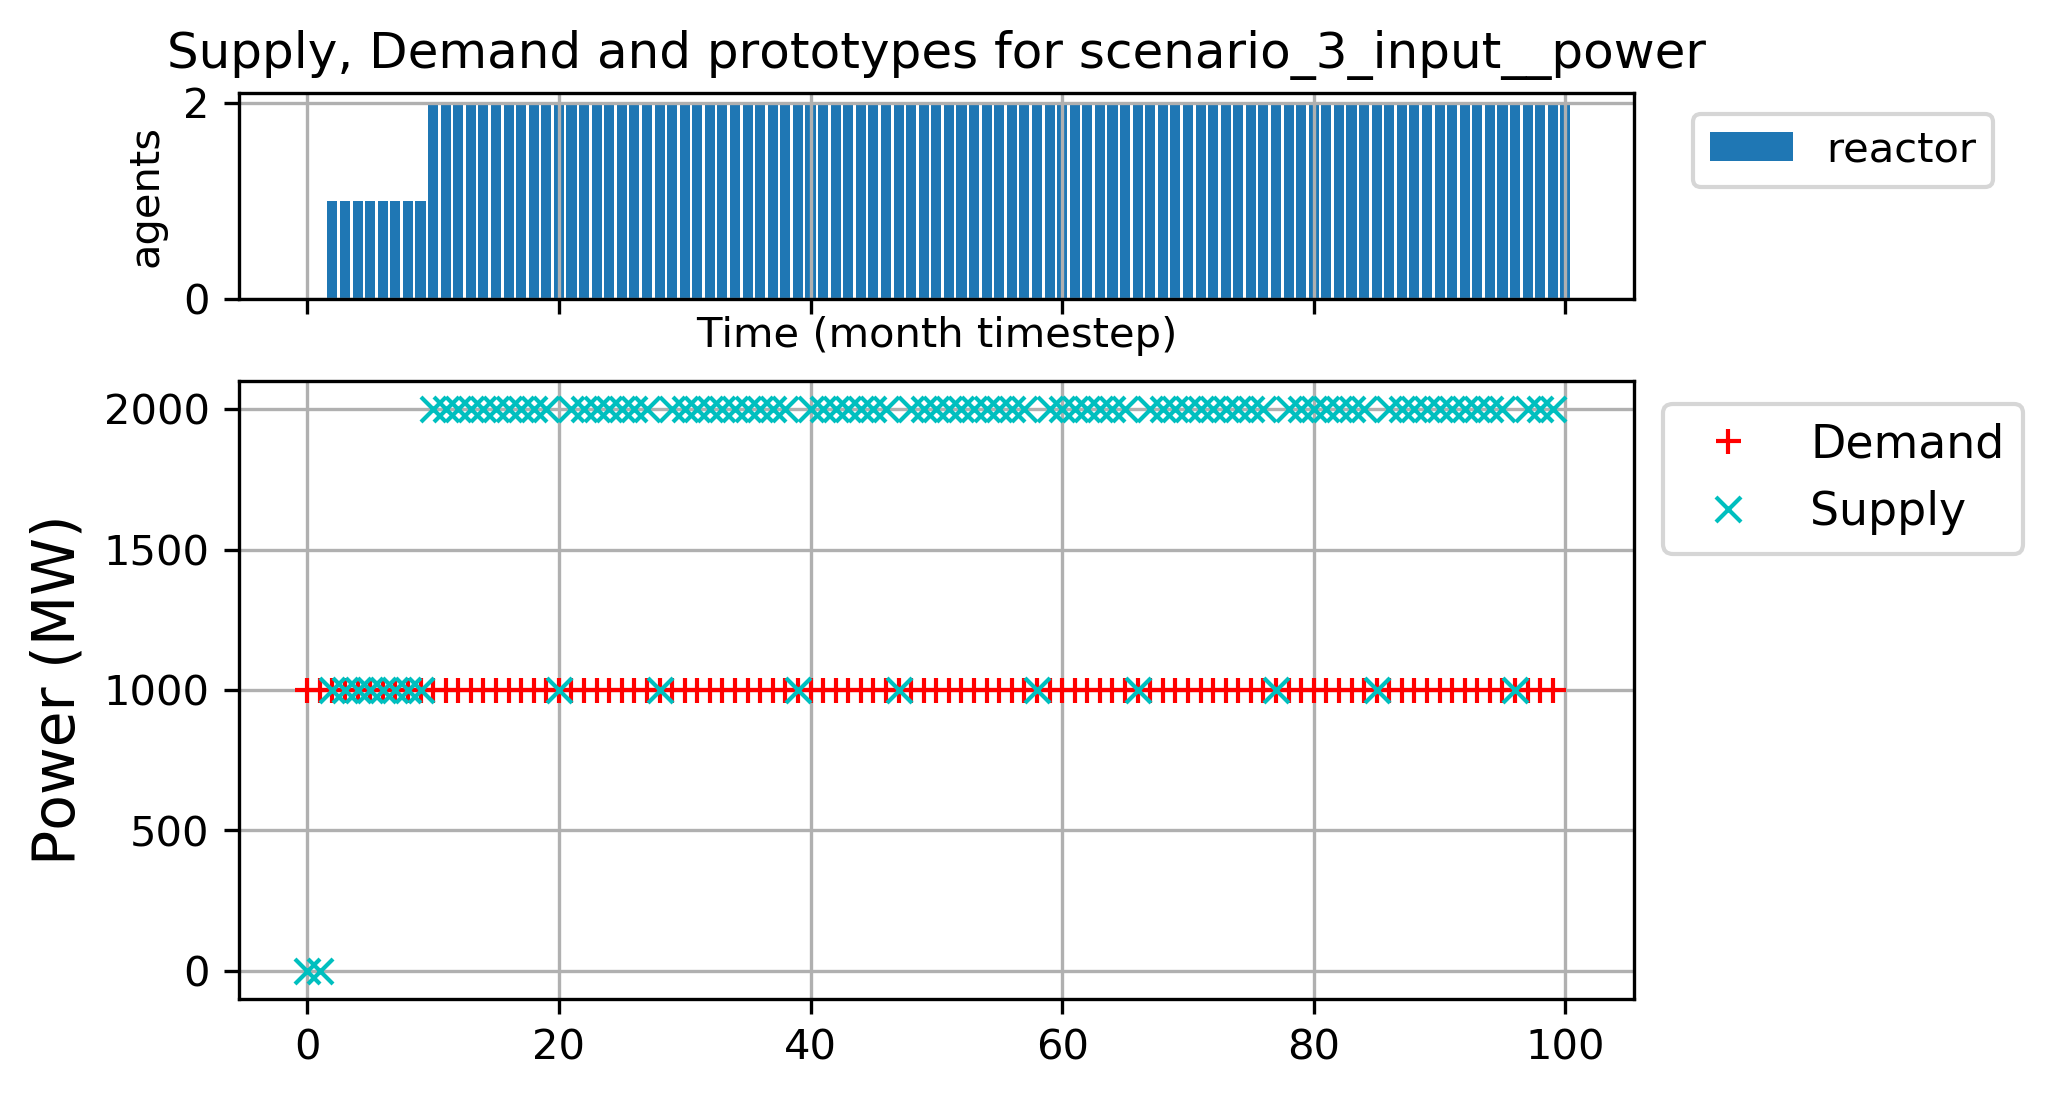

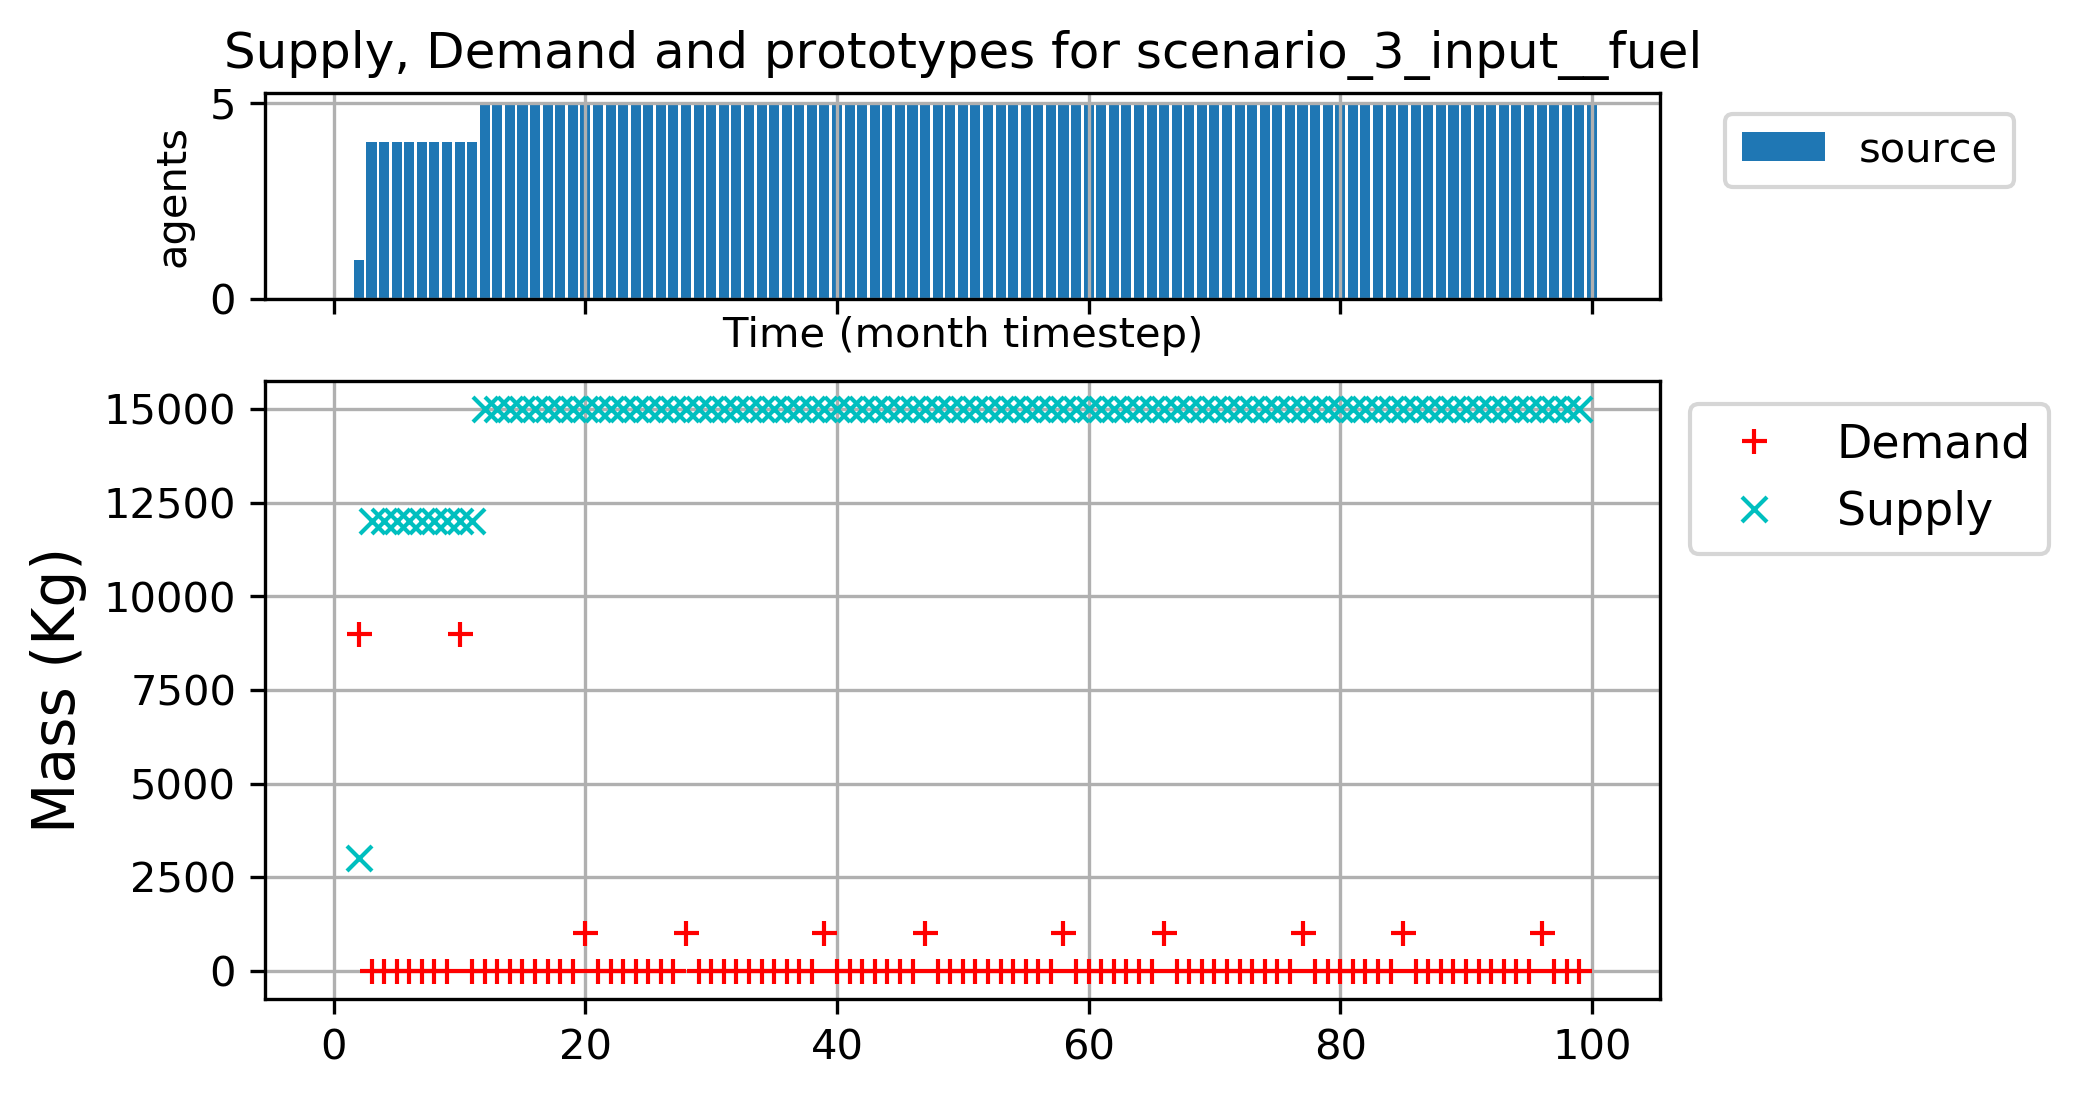

In [45]:
I1 = Image(filename='scenario_3_input__power.png',width=500)
I2 = Image(filename='scenario_3_input__fuel.png',width=500)
display(I1,I2)

In [62]:
df

,power_undersupply,fuel_undersupply
scenario3,7,1


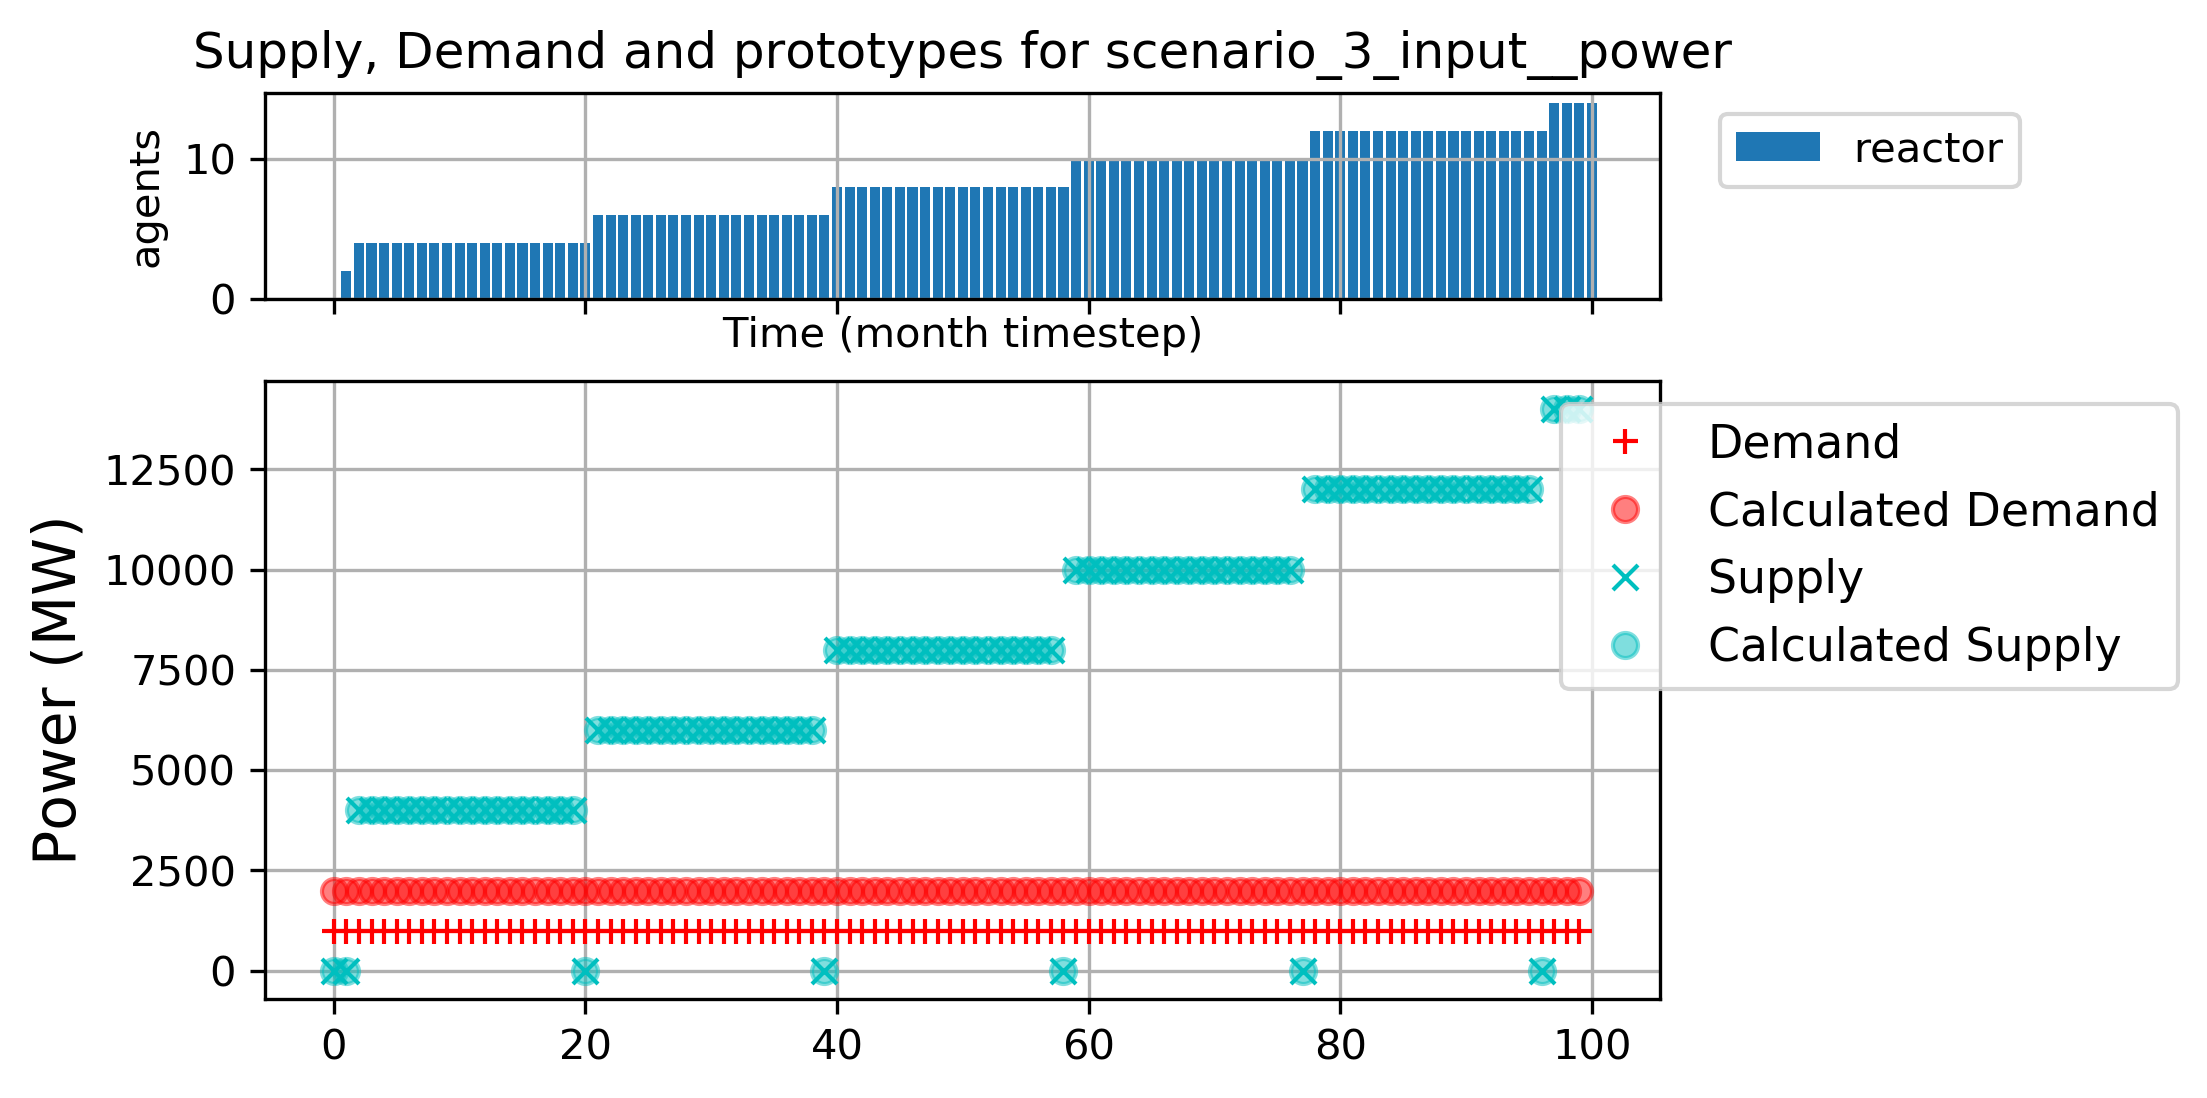

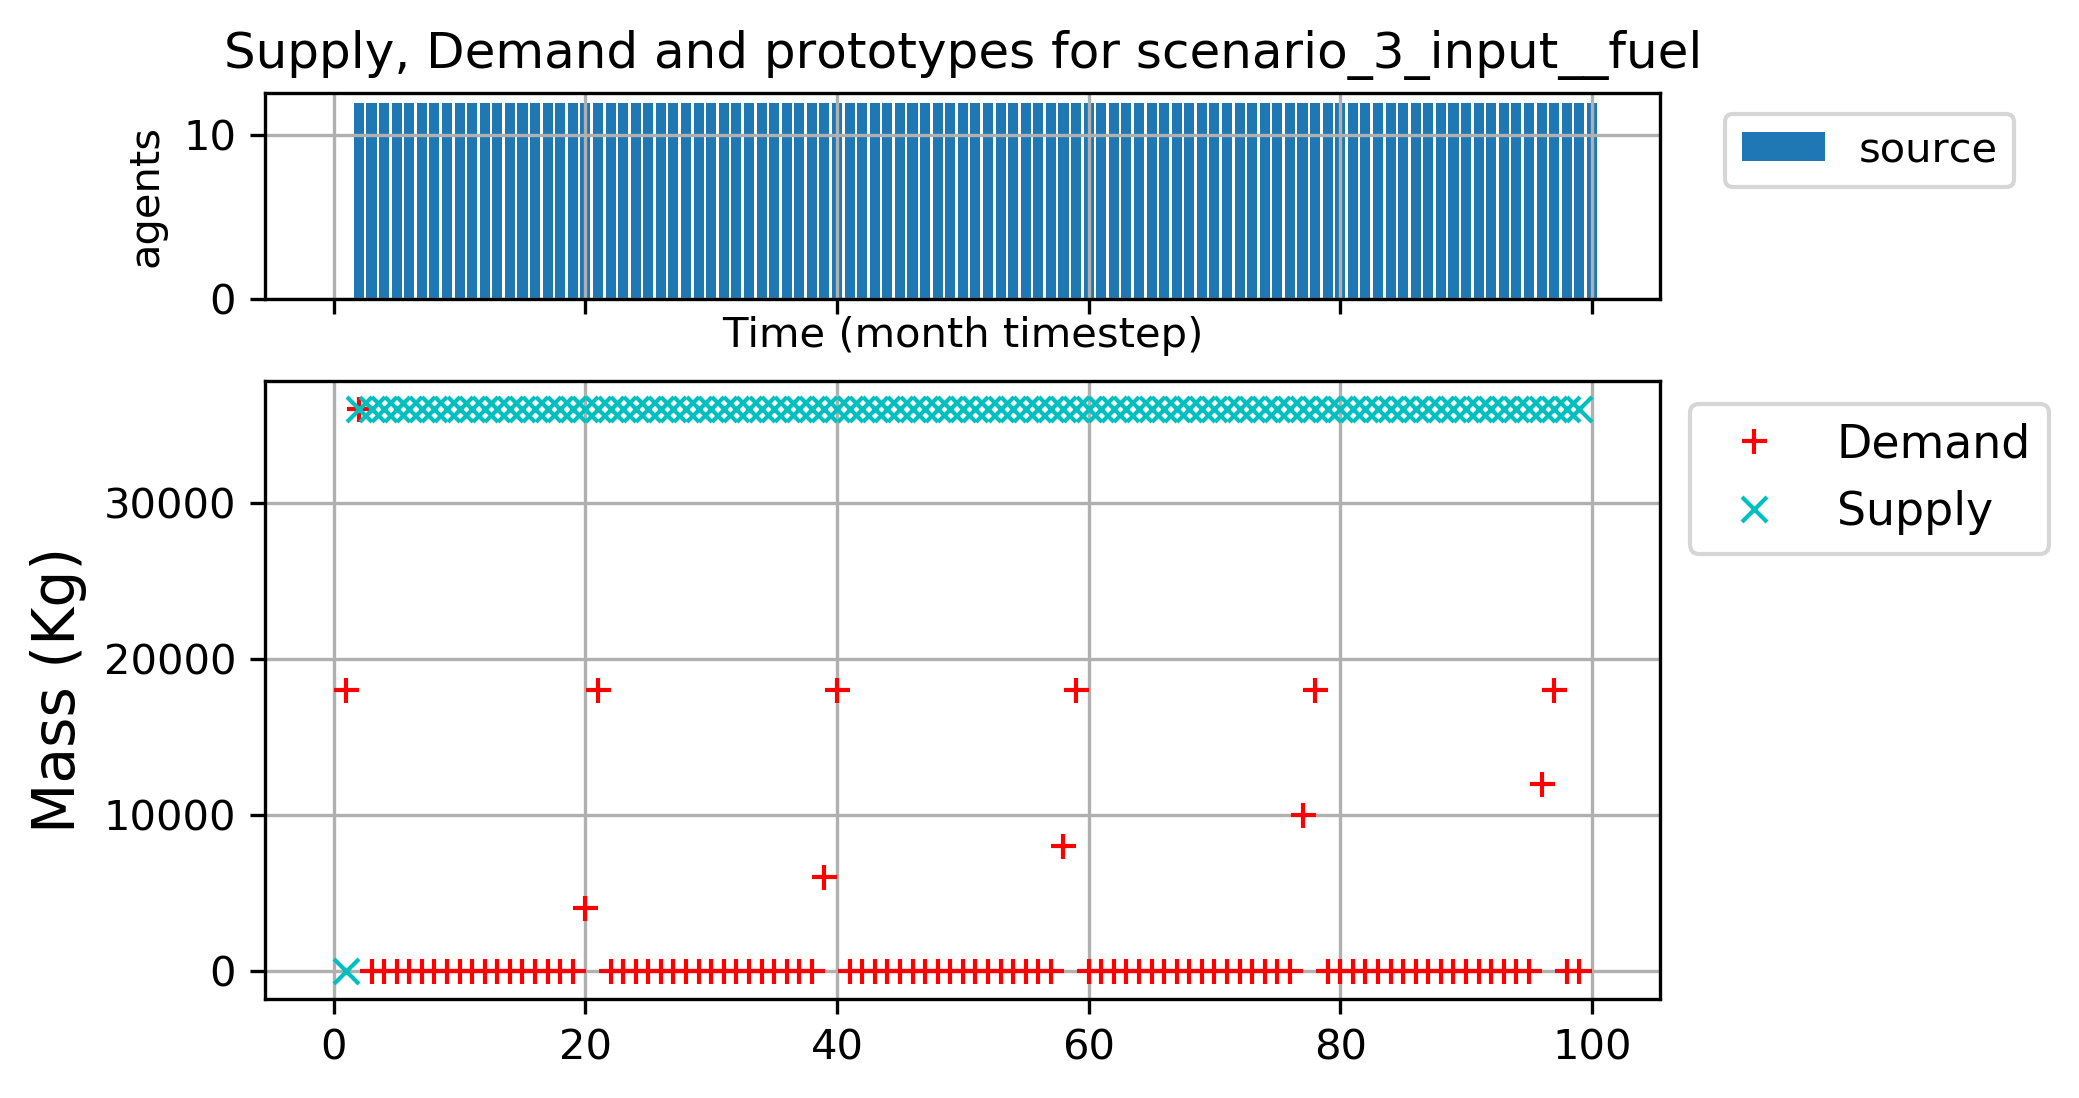

In [63]:
I1 = Image(filename='scenario_3_input__power.png',width=500)
I2 = Image(filename='scenario_3_input__fuel.png',width=500)
display(I1,I2)